<a href="https://colab.research.google.com/github/TwistedAlex/TensorFlow2Practice/blob/main/EAGER_EXE_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Eager execution**
Evaluate operations immediately, without building graphs: operations *return concrete values* instead of constructing a compuational graph to run later. 
  *An intuitive interface*: Structure your code naturally and use Python data structures. Quickly iterate on small models and small data.
  *Easier debugging*: Call ops directly to inspect running models and test changes. Use standard Python debugging toools for immediate error report.
  *Natural control flow*: Use Python control flow instead of graph control flow, simplifying the specification of dynamic models.

**Setup and basic usage**

In [3]:
import os
import tensorflow as tf
import cProfile
tf.compat.v1.enable_eager_execution()

In [ ]:
# Eager execution is enabled by default in TF2.0

tf.executing_eagerly()
# Run TF ops and the results will return immediately:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))
a = tf.constant([[1, 2], [3, 4]])
print(a)

hello, [[4.]]
tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


Broadcasting

In [ ]:
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


Operator overloading

In [ ]:
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


Use NumPy values

In [ ]:
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


Obtain numpy value from a tensor:

In [ ]:
print(a.numpy())

[[1 2]
 [3 4]]


**Dynamic control flow**

A major benefit of eager execution is that all the functionality of the host language is available while your model is executing. So, for example, it is easy to write fizzbuzz:

In [ ]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

This has conditionals that depend on tensor values and it prints these values at runtime.

In [ ]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


**Eager training**

Computing gradients

**Automatic differentiation** is useful for implementing machine learning algorithms such as backpropagation for training neural networks. During eager execution, use tf.GradientTape to trace operations for computing gradients later.

You can use [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to train and/or compute gradients in eager. It is especially useful for complicated training loops.


Args

persistent: Boolean controlling whether a persistent gradient tape is created. False by default, which means at most one call can be made to the gradient() method on this object.

watch_accessed_variables: Boolean controlling whether the tape will automatically watch any (trainable) variables accessed while the tape is active. Defaults to True meaning gradients can be requested from any result computed in the tape derived from reading a trainable Variable. If False users must explicitly watch any Variables they want to request gradients from.



In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


**Train a model**

The following example creates a **multi-layer model** that **classifies** the standard MNIST handwritten digits. It demonstrates the optimizer and layer APIs to build trainable graphs in an eager execution environment.

Trainable variables (created by tf.Variable or tf.compat.v1.get_variable, where trainable=True is default in both cases) are **automatically watched**. Tensors can be manually watched by invoking the watch method on this context manager.

In [ ]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

Even without training, call the model and inspect the output in eager execution:

In [ ]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[-0.01716779 -0.01314864 -0.04200247 -0.02626937  0.00352457  0.03238138
  -0.03156129  0.01748437 -0.0146309  -0.01443066]]


While keras models have a builtin training loop (using the **fit**(next example) method), sometimes you need more **customization**(below). Here's an example, of a training loop implemented with eager:

In [ ]:
optimizer = tf.keras.optimizers.Adam()

# The loss function to be optimized
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [ ]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)

    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  # grads = d(loss)/d(param)
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [ ]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [ ]:
train(epochs = 5)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


Text(0, 0.5, 'Loss [entropy]')

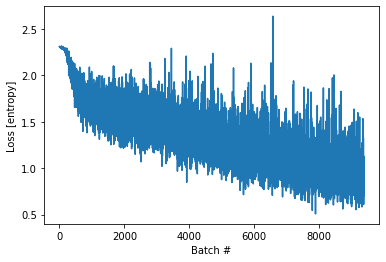

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

**Variables and optimizers**
[tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) objects store mutable [tf.Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor)-like values accessed during training to make automatic differentiation easier.

The collections of variables can be encapsulated into layers or models, along with methods that operate on them. See Custom Keras layers and models for details. The main difference between layers and models is that models add methods like Model.fit, Model.evaluate, and Model.save.

For example, the automatic differentiation example above can be rewritten:

In [13]:
# Model class
class Linear(tf.keras.Model):
  def __init__(self):
    super(Linear, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

In [14]:
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])



1.   Create the model.
2.   The Derivatives of a loss function with respect to model parameters.
3.   A strategy for updating the variables based on the derivatives.



In [15]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

steps = 300
for i in range(steps):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

Initial loss: 69.399
Loss at step 000: 66.700
Loss at step 020: 30.356
Loss at step 040: 14.098
Loss at step 060: 6.824
Loss at step 080: 3.570
Loss at step 100: 2.114
Loss at step 120: 1.463
Loss at step 140: 1.171
Loss at step 160: 1.041
Loss at step 180: 0.982
Loss at step 200: 0.956
Loss at step 220: 0.944
Loss at step 240: 0.939
Loss at step 260: 0.937
Loss at step 280: 0.936


In [16]:
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Final loss: 0.935


In [17]:
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

W = 2.9885663986206055, B = 1.9746339321136475


In [19]:
print(model.call(3))

tf.Tensor(10.940333, shape=(), dtype=float32)


**Object-based saving**

A tf.keras.Model includes a convenient save_weights method allowing you to easily create a checkpoint:

In [20]:
model.save_weights('weights')
status = model.load_weights('weights')

Using [tf.train.Checkpoint](https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint) you can take full control over this process.

This section is an abbreviated version of the guide to training [checkpoints](https://www.tensorflow.org/guide/checkpoint).

In [21]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [22]:
x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [23]:
x.assign(11.)  # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


To save and load models, tf.train.Checkpoint stores the internal state of objects, without requiring hidden variables. To record the state of a model, an optimizer, and a global step, pass them to a tf.train.Checkpoint:

In [24]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

**Object-oriented metrics**

tf.keras.metrics are stored as objects. Update a metric by passing the new data to the callable, and retrieve the result using the tf.keras.metrics.result method, for example:

In [25]:
m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
m.result()  # => 2.5
m([8, 9])
m.result()  # => 5.5

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

**Summaries and TensorBoard**

[TensorBoard](https://www.tensorflow.org/tensorboard) is a visualization tool for understanding, debugging and optimizing the model training process. It uses summary events that are written while executing the program.

You can use [tf.summary](https://www.tensorflow.org/api_docs/python/tf/summary) to record summaries of variable in eager execution. For example, to record summaries of loss once every 100 training steps:

In [ ]:
logdir = "./tb/"
writer = tf.summary.create_file_writer(logdir)

steps = 1000
with writer.as_default():  # or call writer.set_as_default() before the loop.
  for i in range(steps):
    step = i + 1
    # Calculate loss with your real train function.
    loss = 1 - 0.001 * step
    if step % 100 == 0:
      tf.summary.scalar('loss', loss, step=step)

**Advanced automatic differentiation topics**

Dynamic models

tf.GradientTape can also be used in dynamic models. This example for a backtracking line search algorithm looks like normal NumPy code, except there are gradients and is differentiable, despite the complex control flow:

In [26]:
def line_search_step(fn, init_x, rate=1.0):
  with tf.GradientTape() as tape:
    # Variables are automatically tracked.
    # But to calculate a gradient from a tensor, you must `watch` it.
    tape.watch(init_x)
    value = fn(init_x)
  grad = tape.gradient(value, init_x)
  grad_norm = tf.reduce_sum(grad * grad)
  init_value = value
  while value > init_value - rate * grad_norm:
    x = init_x - rate * grad
    value = fn(x)
    rate /= 2.0
  return x, value

Custom gradients

Custom gradients are an easy way to override gradients. Within the forward function, define the gradient with respect to the inputs, outputs, or intermediate results. For example, here's an easy way to clip the norm of the gradients in the backward pass:

In [ ]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
  y = tf.identity(x)
  def grad_fn(dresult):
    return [tf.clip_by_norm(dresult, norm), None]
  return y, grad_fn

Custom gradients are commonly used to provide a numerically stable gradient for a sequence of operations:

In [4]:
def log1pexp(x):
  return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
    # Grad = d(value)/d(x)
  return tape.gradient(value, x)

In [5]:
# The gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [6]:
# However, x = 100 fails because of numerical instability.
grad_log1pexp(tf.constant(100.)).numpy()

nan

In [9]:
print(tf.exp(100.).numpy())

inf


Here, the log1pexp function can be analytically simplified with a custom gradient. The implementation below reuses the value for tf.exp(x) that is computed during the forward pass—making it more efficient by eliminating redundant calculations:

In [ ]:
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)

In [ ]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

In [ ]:
# And the gradient computation also works at x = 100.
grad_log1pexp(tf.constant(100.)).numpy()

**Performance**

Computation is automatically offloaded to GPUs during eager execution. If you want control over where a computation runs you can enclose it in a tf.device('/gpu:0') block (or the CPU equivalent):

In [10]:
import time

def measure(x, steps):
  # TensorFlow initializes a GPU the first time it's used, exclude from timing.
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  # tf.matmul can return before completing the matrix multiplication
  # (e.g., can return after enqueing the operation on a CUDA stream).
  # The x.numpy() call below will ensure that all enqueued operations
  # have completed (and will also copy the result to host memory,
  # so we're including a little more than just the matmul operation
  # time).
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
  print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 6.392500400543213 secs
GPU: not found


A tf.Tensor object can be copied to a different device to execute its operations:

#TODO CHECK AVAILABILITY IN CURRENT VERSION

In [13]:
if tf.config.experimental.list_physical_devices("GPU"):
  x = tf.random.normal([10, 10])

  x_gpu0 = x.gpu()
  x_cpu = x.cpu()

  _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
  _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0

Disable eager execution

In [ ]:
tf.compat.v1.disable_eager_execution()
a = tf.constant([[1, 2], [3, 4]])
print(a)

Tensor("Const:0", shape=(2, 2), dtype=int32)


In [ ]:
b = tf.add(a, 1)
print(b)

Tensor("Add:0", shape=(2, 2), dtype=int32)


In [ ]:
import numpy as np

c = np.multiply(a, b)
print(c)